In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import jax.numpy as jnp
import jax
from jax import grad, vmap, jit, random
from tqdm import tqdm

In [2]:
SEED = 1234
lmbda = 5

In [3]:
key1, key2, key3 = random.split(jax.random.PRNGKey(SEED),3)

data_50 = -lmbda*np.log(jax.random.uniform(key1,[50],minval=0.0,maxval=1.0))
data_500 = -lmbda*np.log(jax.random.uniform(key2,[500],minval=0.0,maxval=1.0))
data_2000 = -lmbda*np.log(jax.random.uniform(key3,[2000],minval=0.0,maxval=1.0))

print(len(data_50), len(data_500), len(data_2000))

50 500 2000


In [4]:
def log_function(lmbd, x):
  return len(x)*jnp.log(lmbd[0]) - 1/lmbd[0] * sum([-xs for xs in x])

In [5]:
def gradLoss(data):
  param = jnp.array([2.2])
  gradFunc = jit(grad(log_function))

  ploss = jnp.abs(param[0]-lmbda)
  lr = 0.01

  for i in range(1000):
    part = gradFunc(param,data)

    param -= (lr * part)

    loss = jnp.abs(param[0]-lmbda)

    if jnp.abs(ploss-loss) < 1e-10:
      print("Finished in iteration: ")
      print(i)
      break
    ploss = loss
  return param

In [6]:
l1 = gradLoss(data_50)
l2 = gradLoss(data_500)
l3 = gradLoss(data_2000)

print(l1, l2, l3)

Finished in iteration: 
615
Finished in iteration: 
59
Finished in iteration: 
17
[5.2542224] [5.277811] [4.823823]


In [7]:
print(data_50.mean(), data_500.mean(), data_2000.mean())

5.2542353 5.277811 4.8238254


In [8]:
SEED2 = 2345

lmbda1 = 3
lmbda2 = 11

In [9]:
key_1, key_2 = random.split(jax.random.PRNGKey(SEED2),2)

data_2500_1 = -lmbda1*np.log(jax.random.uniform(key1,[2500],minval=0.0,maxval=1.0))
data_2500_2 = -lmbda2*np.log(jax.random.uniform(key2,[2500],minval=0.0,maxval=1.0))

data_final = np.concatenate((data_2500_1,data_2500_2))

print(len(data_final), len(data_2500_1), len(data_2500_2))
print(data_final.mean(), data_2500_1.mean(), data_2500_2.mean())

5000 2500 2500
7.0443783 3.0402856 11.0484705


In [10]:
@jax.jit
def func_log(lmbd1,lmbd2,xs):
  return jnp.log(0.5*1/lmbd1[0]*jnp.exp(-xs/lmbd1[0]) + 0.5*1/lmbd2[0]*jnp.exp(-xs/lmbd2[0]))

In [42]:
def gradLoss_2(data):
  param1 = jnp.array([0.5])
  gradFunc1 = jit(grad(func_log,argnums=0)) # first param

  param2 = jnp.array([15.3])
  gradFunc2 = jit(grad(func_log,argnums=1)) # second param

  ploss1 = jnp.abs(param1[0]-lmbda1)
  ploss2 = jnp.abs(param2[0]-lmbda2)

  lr = 0.001

  stop1 = False
  stop2 = False

  paramProg1 = []
  paramProg2 = []

  logProg1 = []
  logProg2 = []

  part1 = -sum(vmap(gradFunc1, in_axes=(None,None, 0))(param1,param2, data))
  part2 = -sum(vmap(gradFunc2, in_axes=(None,None, 0))(param1,param2, data))

  
  paramProg1.append(param1)
  paramProg2.append(param2)

  logProg1.append(part1)
  logProg2.append(part2)

  for i in range(1000):
      if not stop1:
        part1 = -sum(vmap(gradFunc1, in_axes=(None,None, 0))(param1,param2, data))
        param1 -= (lr * part1)

        paramProg1.append(param1)
        logProg1.append(part1)

        loss1 = jnp.abs(param1[0]-lmbda1) 

        if jnp.abs(ploss1-loss1) < 1e-10:
          stop1 = True

        ploss1 = loss1

      if not stop2:
        part2 = -sum(vmap(gradFunc2, in_axes=(None,None, 0))(param1,param2, data))
        param2 -= (lr * part2)

        paramProg2.append(param2)
        logProg2.append(part2)

        loss2 = jnp.abs(param2[0]-lmbda2) 

        if jnp.abs(ploss2-loss2) < 1e-10:
          stop2 = True
      
        ploss2 = loss2

      if stop1 and stop2:
        break


  return param1, param2, paramProg1, logProg1, paramProg2, logProg2

In [43]:
l_pred1, l_pred2, paramProg1, logProg1, paramProg2, logProg2 = gradLoss_2(data_final)

print(l_pred1, l_pred2)

[3.0546207] [11.0590315]


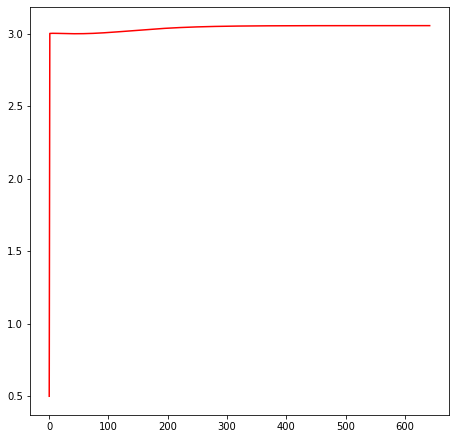

In [49]:
it1 = np.arange(len(paramProg1))
it2 = np.arange(len(paramProg2))

fig = plt.figure(figsize=(7.5,7.5))
plt.plot(it1,paramProg1, 'red')

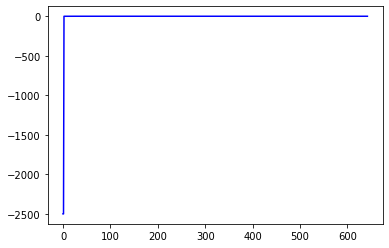

In [45]:
plt.plot(it1,logProg1, 'blue')

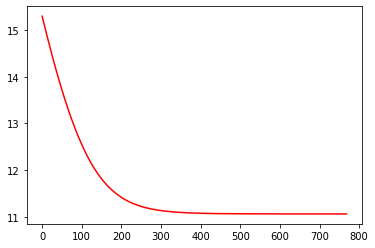

In [46]:
plt.plot(it2,paramProg2, 'red')

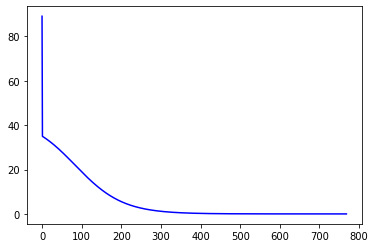

In [47]:
plt.plot(it2,logProg2, 'blue')